# Praca domowa 5

**17.05.2020r.**

**Agata Makarewicz**

## Wczytanie potrzebnych pakietów

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Wczytanie danych

In [2]:
np.random.seed(123) 

# wczytanie danych
data = pd.read_csv('../../clustering.csv', names=['x','y'])
data.head()

,x,y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       400 non-null    float64
 1   y       400 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


Mamy zbiór 400 obserwacji w wymiarze $R^{2}$, które nie są przypisane do żadnej klasy. Obie kolumny są typu float, nie mamy również żadnych brakujących wartości. Nasze dane to po prostu współrzędne punktów w przestrzeni.

In [4]:
data.describe()

,x,y
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


## Wizualizacja danych

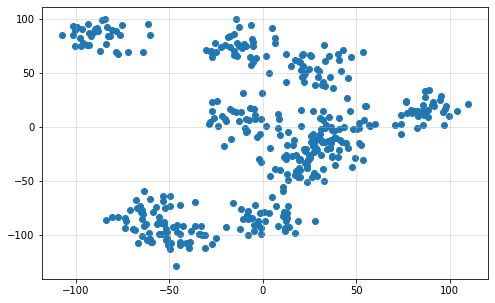

In [5]:
plt.figure(figsize=(8,5))
plt.scatter(data['x'], data['y'])
plt.grid(alpha=0.4)
plt.show()

## Klasteryzacja

Przeprowadzimy klasteryzację za pomocą 2 metod:

* k-średnich
* aglomeracyjna

W przypadku algorytmu k-średnich optymalną liczbę klastrów za pomocą metody łokcia, w przypadku metody aglomeracyjnej - metodą Silhouette. 

### Metoda k-średnich

**Wyznaczenie optymalnej liczby klastrów - metoda łokcia**

In [6]:
def elbow_method(data, k_max):
    inertias = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

In [7]:
def plot_elbow(data, k_max):
    plt.figure(figsize=(8,5))
    y = elbow_method(data, k_max)
    x = list(range(1, len(y) + 1))
    plt.plot(x, y, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method showing the optimal k')
    plt.xticks(x)
    plt.show()

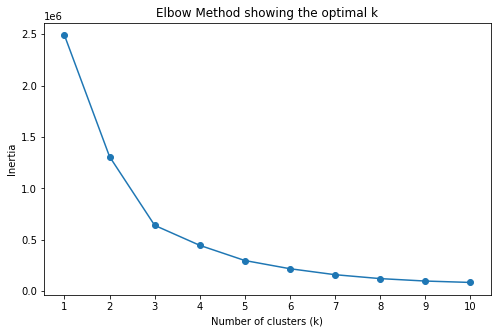

In [8]:
plot_elbow(data,10)

Aby wyznaczyć optymalną liczbę klastrów, szukamy punktu "przegięcia", tzn. punktu, w którym wartość "Inertia" zaczyna wolniej maleć. W tym przypadku ten punkt to 3 (choć oczywiście jest to subiektywny wybór) - a zatem taką liczbę klastrów podajemy w modelu.

**Klasteryzacja**

In [9]:
def kmeans_model(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    labels = kmeans.predict(data)
    return labels, kmeans

In [10]:
def kmeans_plot(data,k):
    labels, kmeans = kmeans_model(data,k)
    plt.figure(figsize=(8,5))
    plt.scatter(data['x'], data['y'], c=labels, s=30, cmap='viridis', alpha=0.7)
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:,0],centroids[:,1], marker='D',s=70,c='blue')
    plt.title('K-means clusters')
    plt.grid(alpha=0.4)
    plt.show()

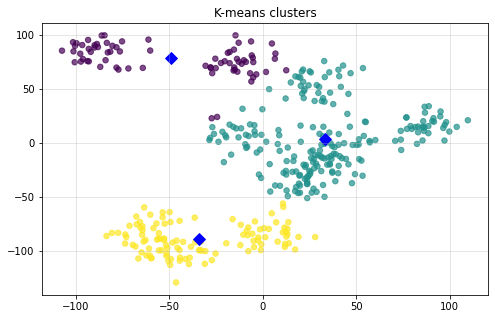

In [11]:
kmeans_plot(data,3)

Widzimy, że podział jest dość adekwatny, chociaż górny klaster nie jest zbyt dobrze "wydzielony". Wróćmy zatem do metody łokcia. Zauważmy, że powyżej sprawdziliśmy liczbę klastrów do 10. Zobaczmy, jaki będzie punkt przegięcia gdy weźmiemy większy zakres.

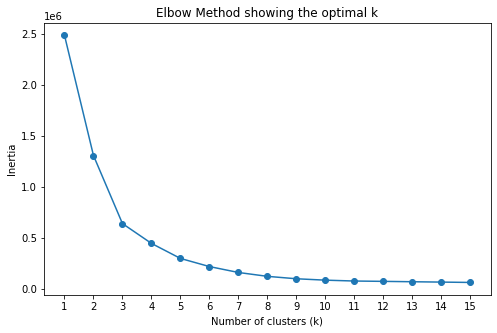

In [12]:
plot_elbow(data,15)

Widzimy, że gdy sprwadzimy liczbę klastrów aż do 15, punkt przegięcia w 3 nie jest aż tak wyraźny - równie prawdopodobna jest wartość 4 czy 5. Zobaczmy zatem jak działa KMeans dla takiej liczby klastrów.

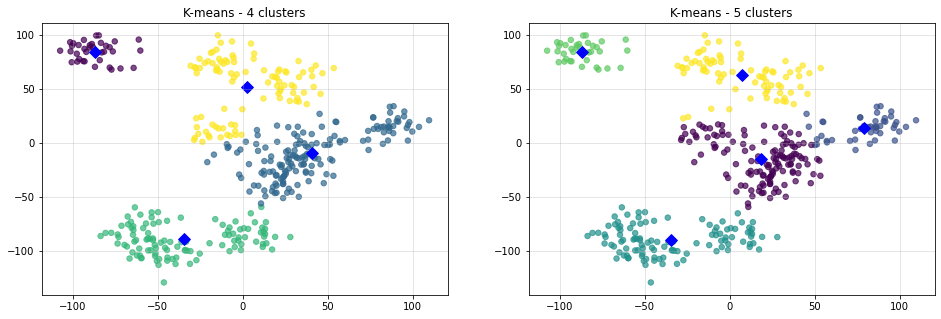

In [13]:
plt.figure(figsize=(16,5))
# 4 klastrów
plt.subplot(121)
labels, kmeans = kmeans_model(data,4)
plt.scatter(data['x'], data['y'], c=labels, s=30, cmap='viridis', alpha=0.7)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1], marker='D',s=70,c='blue')
plt.title('K-means - 4 clusters')
plt.grid(alpha=0.4)
# 5 klastrów
plt.subplot(122)
labels, kmeans = kmeans_model(data,5)
plt.scatter(data['x'], data['y'], c=labels, s=30, cmap='viridis', alpha=0.7)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1], marker='D',s=70,c='blue')
plt.title('K-means - 5 clusters')
plt.grid(alpha=0.4)
plt.show()

Jak widać, te podziały na 4 i 5 klastrów są bardziej adekwatne niż na 3. Patrząc na powyższe wykresy najbardziej optymalnym podziałem z rozważanych wydaje się ten na 5 klastrów.

### Metoda aglomeracyjna

**Wyznaczenie optymalnej liczby klastrów - metoda Silhouette**

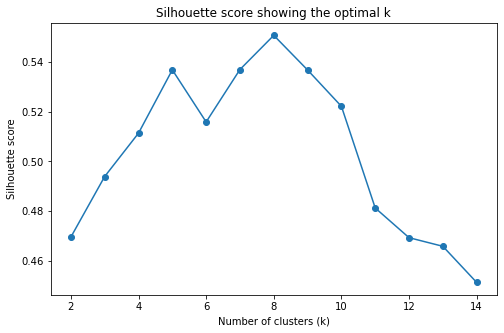

In [14]:
cluster_num = range(2, 15)
   
scores = []    
for k in cluster_num:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(data)
    score = silhouette_score(data, labels)
    scores.append(score)
    
plt.figure(figsize=(8,5))
plt.plot(cluster_num, scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette score showing the optimal k')
plt.show()

Na podstawie powyższego wykresu widzimy, że optymalną liczbą klasterów jest 8 - taką zatem wartość przekazujemy do modelu. 

**Klasteryzacja**

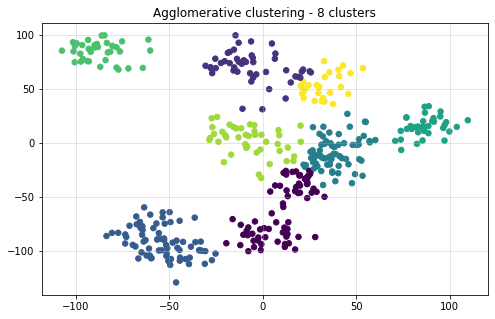

In [15]:
model = AgglomerativeClustering(n_clusters=8, linkage='complete')
labels = model.fit_predict(data)

plt.figure(figsize=(8,5))
plt.scatter(data['x'], data['y'], c=labels, s=30, cmap='viridis')
#centroids = model.cluster_centers_
#plt.scatter(centroids[:,0],centroids[:,1], marker='D',s=70,c='blue')
plt.title('Agglomerative clustering - 8 clusters')
plt.grid(alpha=0.4)
plt.show()

Jak widać powyżej, podział na 8 klastrów wydaje się być faktycznie najbardziej optymalnym. Używamy metody *complete* - odległość między klastrami to maksymalna odległość pomiędzy obserwacjami. Spójrzmy jeszcze na etapy łączenia poszczególnych klastrów, co widzimy poniżej. Pozioma linia oznacza próg/odległość (parametr "threshold"), dla którego mamy 8 klastrów. Widać tutaj dlaczego również podział na 7 czy 9 klastrów miał bardzo dobry wynik metryki silhouette - próg jest minimalnie wyższy dla 7 i minimalnie niższy dla 9.

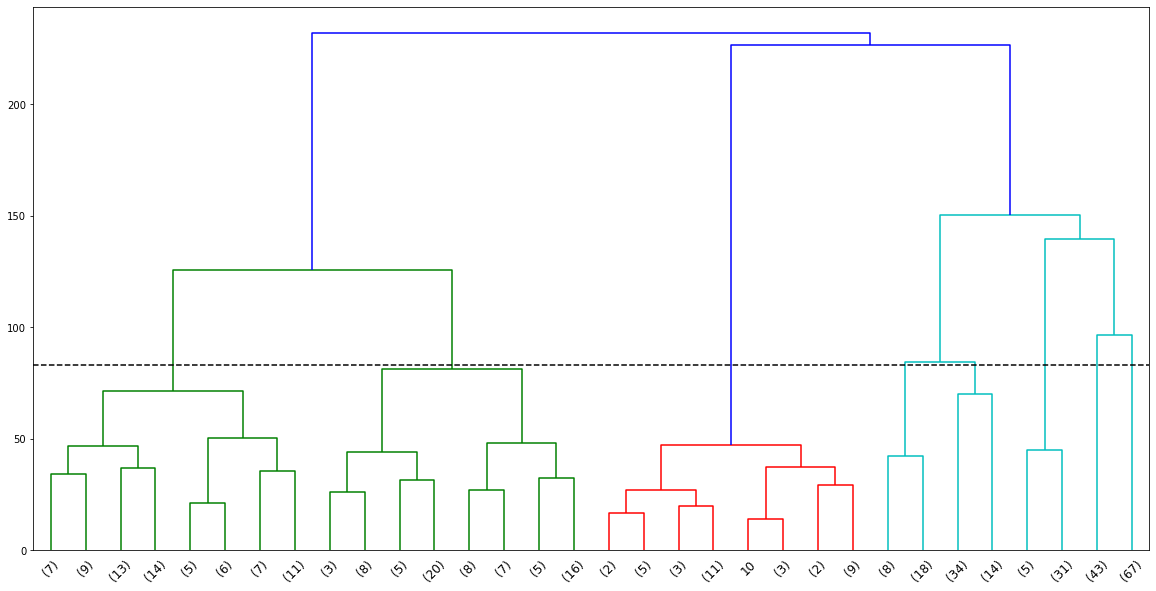

In [16]:
mergings = linkage(data, method='complete')
plt.figure(figsize=(20,10))
dendrogram(mergings, leaf_font_size=12, leaf_rotation=45, p=4, truncate_mode='level')
plt.axhline(83, color='black', linestyle='--')
plt.show()